# WEEK 3

In [2]:
from google.colab import drive
import os, shutil

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Copy your UTKFace repository into the VM for sampling
src_dir = '/content/drive/MyDrive/icici_w1-4'  # adjust if your folder is elsewhere
dst_dir = '/content/raw_utkface'
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    for f in os.listdir(src_dir):
        if f.lower().endswith('.jpg'):
            shutil.copy(os.path.join(src_dir, f), dst_dir)
print(f"Raw UTKFace copied → {len(os.listdir(dst_dir))} images")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Raw UTKFace copied → 0 images


In [ ]:
import os, numpy as np, pandas as pd, shutil

image_dir = '/content/raw_utkface'
file_names = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]

# Parse metadata from filename
records = []
for fname in file_names:
    parts = fname.split('.')[0].split('_')
    try:
        age, gender, race = int(parts[0]), int(parts[1]), int(parts[2])
        records.append((os.path.join(image_dir, fname), age, gender, race))
    except:
        continue

df = pd.DataFrame(records, columns=['file_path','age','gender','race'])

# Create 5-year bins + final 80+
bins   = list(range(0,81,5)) + [120]
labels = [f"{i}-{i+4}" for i in range(0,80,5)] + ['80+']
df['age_bin'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Sample 2 per (race, gender, age_bin)
sampled = []
for (r,g,bin_), grp in df.groupby(['race','gender','age_bin'], observed=True):
    if len(grp)>=2:
        idxs = np.linspace(0,len(grp)-1,2,dtype=int)
        sampled.append(grp.iloc[idxs])
    else:
        sampled.append(grp)
sampled_df = pd.concat(sampled, ignore_index=True)

# Ensure ≥20 per race
out = []
for race_id in df['race'].unique():
    sub = sampled_df[sampled_df['race']==race_id]
    if len(sub)>=20:
        out.append(sub)
    else:
        needed = 20-len(sub)
        pool = df[(df['race']==race_id)&(~df['file_path'].isin(sub['file_path']))]
        extra = pool.sample(n=min(needed,len(pool)), random_state=42)
        out.append(pd.concat([sub,extra], ignore_index=True))
final_df = pd.concat(out, ignore_index=True)

# Optionally fill up to ~120
if len(final_df)<120:
    needed = 120-len(final_df)
    pool = df[~df['file_path'].isin(final_df['file_path'])]
    extra = pool.sample(n=min(needed,len(pool)), random_state=42)
    final_df = pd.concat([final_df, extra], ignore_index=True)

# Copy to ./sampled_images
os.makedirs('sampled_images', exist_ok=True)
for path in final_df['file_path']:
    shutil.copy(path, 'sampled_images')

print("Sampled images:", len(final_df))
print(final_df['race'].value_counts().sort_index())

Sampled images: 120
race
0    26
1    21
2    23
3    29
4    21
Name: count, dtype: int64


Age stats:
 count    120.000000
mean      43.583333
std       30.697654
min        1.000000
25%       20.000000
50%       41.000000
75%       63.000000
max      110.000000
Name: age, dtype: float64 

Gender counts:
 gender
1    62
0    58
Name: count, dtype: int64 

Race counts:
 race
3    29
0    26
2    23
1    21
4    21
Name: count, dtype: int64 



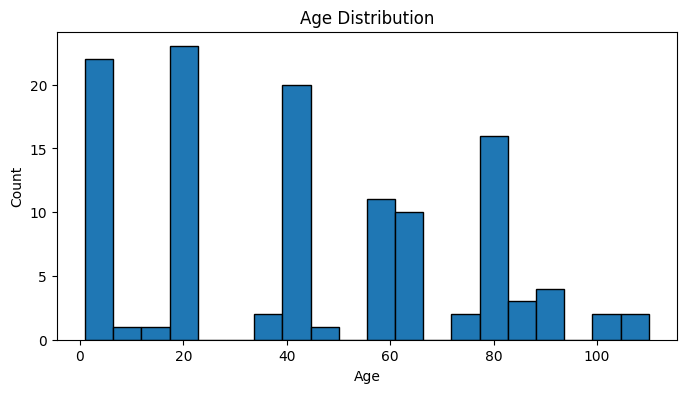

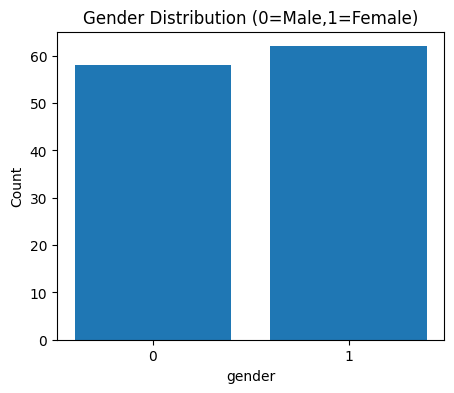

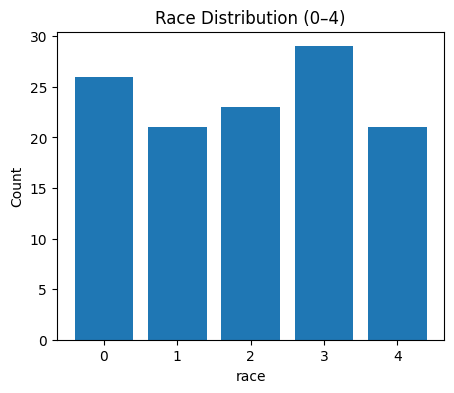

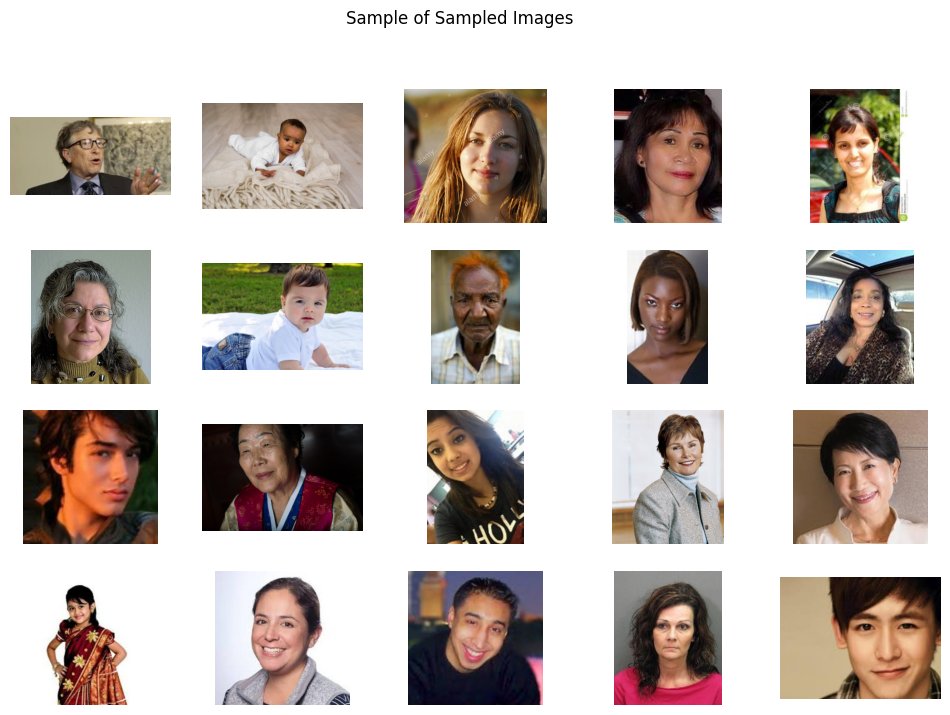

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# 3.1 Basic stats
ages = final_df['age']
print("Age stats:\n", ages.describe(), "\n")
print("Gender counts:\n", final_df['gender'].value_counts(), "\n")
print("Race counts:\n", final_df['race'].value_counts(), "\n")

# 3.2 Age histogram
plt.figure(figsize=(8,4))
plt.hist(ages, bins=20, edgecolor='black')
plt.title('Age Distribution'); plt.xlabel('Age'); plt.ylabel('Count')
plt.show()

# 3.3 Gender & Race bar charts
for col, title in [('gender','Gender Distribution (0=Male,1=Female)'),
                   ('race','Race Distribution (0–4)')]:
    cnt = final_df[col].value_counts().sort_index()
    plt.figure(figsize=(5,4))
    plt.bar(cnt.index.astype(str), cnt.values)
    plt.title(title); plt.xlabel(col); plt.ylabel('Count')
    plt.show()

# 3.4 Sample image grid
imgs = random.sample(final_df['file_path'].tolist(), min(20,len(final_df)))
plt.figure(figsize=(12,8))
for i,p in enumerate(imgs):
    img = Image.open(p)
    plt.subplot(4,5,i+1); plt.imshow(img); plt.axis('off')
plt.suptitle('Sample of Sampled Images'); plt.show()

In [ ]:
import cv2, numpy as np, os

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
eye_cascade  = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_eye.xml')

def align_face(path):
    img = cv2.imread(path)
    if img is None: return None, False
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.1,5)
    if len(faces)==0: return None, False
    x,y,w,h = faces[0]
    roi = gray[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi)
    if len(eyes)<2: return None, False
    eyes = sorted(eyes, key=lambda e:e[2], reverse=True)[:2]
    centers = [(x+ex+ew//2, y+ey+eh//2) for ex,ey,ew,eh in eyes]
    left, right = sorted(centers, key=lambda c:c[0])[:2]
    dx, dy = right[0]-left[0], right[1]-left[1]
    angle = float(np.degrees(np.arctan2(dy, dx)))
    center = (int((left[0]+right[0])/2), int((left[1]+right[1])/2))
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    aligned = cv2.warpAffine(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_CUBIC)
    return aligned, True

os.makedirs('aligned_images', exist_ok=True)
aligned, failed = [], []
for f in os.listdir('sampled_images'):
    src = os.path.join('sampled_images', f)
    img, ok = align_face(src)
    if ok:
        cv2.imwrite(os.path.join('aligned_images', f), img); aligned.append(f)
    else:
        failed.append(f)

print("Aligned:", len(aligned), "Failed:", len(failed))

Aligned: 79 Failed: 41


In [ ]:
import cv2, os

BLUR_THR=100.0
os.makedirs('cleaned_images', exist_ok=True)

blurry, occluded, clean = [], [], []
for f in os.listdir('aligned_images'):
    path = os.path.join('aligned_images', f)
    img = cv2.imread(path); gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if cv2.Laplacian(gray,cv2.CV_64F).var() < BLUR_THR:
        blurry.append(f); continue
    faces = face_cascade.detectMultiScale(gray,1.1,5)
    if len(faces)==0:
        occluded.append((f,'no_face')); continue
    x,y,w,h = faces[0]
    roi = gray[y:y+h, x:x+w]
    if len(eye_cascade.detectMultiScale(roi))<2:
        occluded.append((f,'few_eyes')); continue
    clean.append(f)
    cv2.imwrite(os.path.join('cleaned_images', f), img)

print("Blurry:", len(blurry), "Occluded:", len(occluded), "Clean:", len(clean))

Blurry: 18 Occluded: 11 Clean: 50


In [ ]:
import cv2, os

os.makedirs('cropped_images', exist_ok=True)
fail_crop = []

for f in os.listdir('cleaned_images'):
    src = os.path.join('cleaned_images', f)
    img = cv2.imread(src); gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.1,5, minSize=(50,50))
    if not faces.any():
        fail_crop.append(f); continue
    x,y,w,h = sorted(faces, key=lambda r:r[2]*r[3], reverse=True)[0]
    pad_w, pad_h = int(0.1*w), int(0.1*h)
    x1, y1 = max(x-pad_w,0), max(y-pad_h,0)
    x2 = min(x+w+pad_w, img.shape[1]-1); y2 = min(y+h+pad_h, img.shape[0]-1)
    crop = img[y1:y2, x1:x2]
    out = cv2.resize(crop, (224,224), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(os.path.join('cropped_images', f), out)

print("Cropped:", len(os.listdir('cropped_images')), "Failed:", len(fail_crop))

Cropped: 50 Failed: 0


count     50.00000
mean      41.78000
std       27.21291
min        1.00000
25%       21.00000
50%       40.50000
75%       60.75000
max      101.00000
Name: age, dtype: float64
Gender
 gender
1    28
0    22
Name: count, dtype: int64 

Race
 race
3    13
0    12
2    11
1     7
4     7
Name: count, dtype: int64 

Duplicates: None


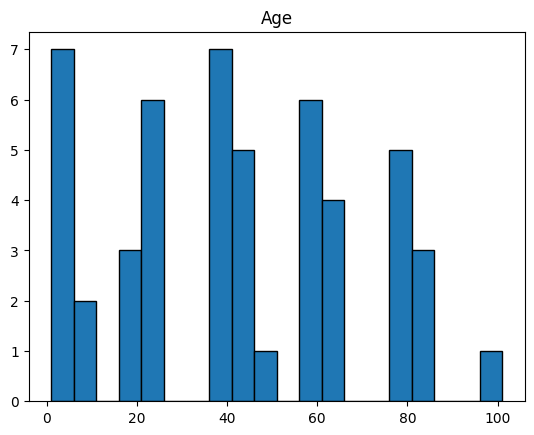

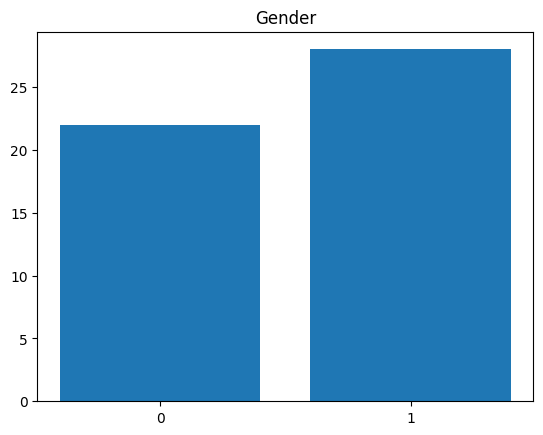

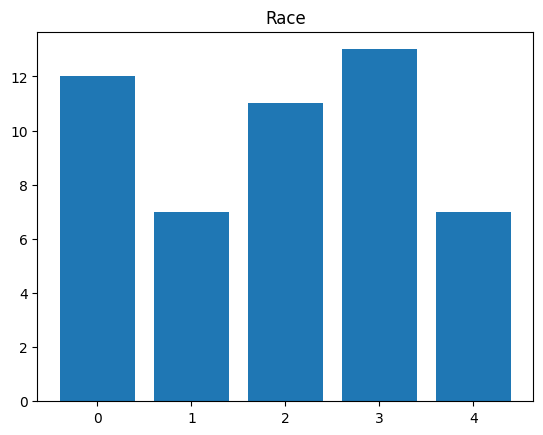

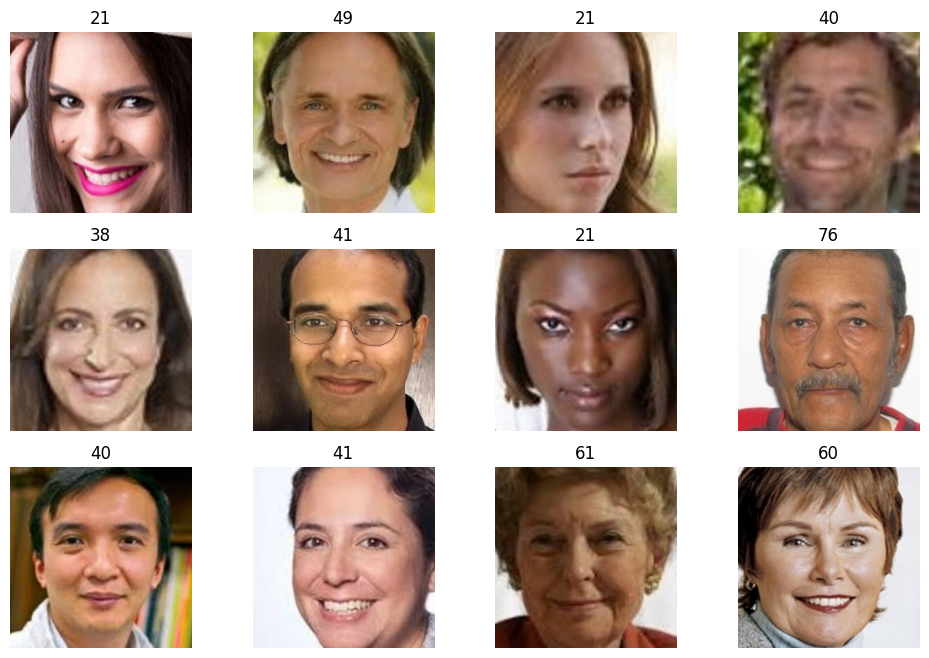

In [ ]:
import os, cv2, pandas as pd, matplotlib.pyplot as plt, hashlib

dirc = 'cropped_images'
files = [f for f in os.listdir(dirc) if f.lower().endswith('.jpg')]

# Build metadata DF
rows=[]
for f in files:
    a,g,r,_ = f.split('.')[0].split('_')
    rows.append((f,int(a),int(g),int(r)))
df = pd.DataFrame(rows, columns=['file','age','gender','race'])

# Stats
print(df['age'].describe())
print("Gender\n", df['gender'].value_counts(), "\n")
print("Race\n", df['race'].value_counts(), "\n")

# Duplicate check
hmap,dups={},[]
for f in df['file']:
    b = cv2.imencode('.jpg',cv2.imread(os.path.join(dirc,f)))[1].tobytes()
    h=hashlib.md5(b).hexdigest()
    if h in hmap: dups.append((f,hmap[h]))
    else: hmap[h]=f
print("Duplicates:", dups or "None")

# Plots
plt.hist(df['age'], bins=20, edgecolor='black'); plt.title('Age'); plt.show()
for col,title in [('gender','Gender'),('race','Race')]:
    cnt=df[col].value_counts().sort_index()
    plt.bar(cnt.index.astype(str),cnt.values); plt.title(title); plt.show()

# Sample grid
import random
imgs = random.sample(files, min(12,len(files)))
plt.figure(figsize=(12,8))
for i,f in enumerate(imgs):
    plt.subplot(3,4,i+1)
    im = cv2.cvtColor(cv2.imread(os.path.join(dirc,f)),cv2.COLOR_BGR2RGB)
    plt.imshow(im); plt.title(df[df['file']==f]['age'].item()); plt.axis('off')
plt.show()

# WEEK 4

In [1]:
# Core DL frameworks
!pip install torch torchvision
!pip install tensorflow

# Face-recognition libraries
!pip install facenet-pytorch
!pip install keras-vggface

# Age/race estimation
!pip install deepface
!pip install insightface

  Using cached insightface-0.7.3.tar.gz (439 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached onnx-1.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.9 kB)
Using cached onnx-1.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1060437 sha256=5c32e5737f39b9f7f16d95ec1cc10f4bfbb6a31782b59b480d727303298a7898
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface


In [5]:
import os
import torch
import numpy as np
from PIL import Image
from facenet_pytorch import InceptionResnetV1

# 1) Select a small batch of sample images
sample_dir = '/content/drive/MyDrive/icici_w1-4'
all_imgs = sorted([os.path.join(sample_dir, f)
                   for f in os.listdir(sample_dir) if f.lower().endswith('.jpg')])
samples = all_imgs[:10]  # first 10

# 2) Initialize the FaceNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# 3) Preprocess & compute embeddings
embeddings = []
for img_path in samples:
    img = Image.open(img_path).convert('RGB').resize((160,160))
    tensor = (torch.tensor(np.array(img))
              .permute(2,0,1)
              .unsqueeze(0)
              .float() / 255.0
             ).to(device)
    with torch.no_grad():
        emb = facenet(tensor).cpu().numpy()[0]
    embeddings.append(emb)

print(f"✔️ Generated {len(embeddings)} embeddings, each of dimension {embeddings[0].shape}")

  0%|          | 0.00/107M [00:00<?, ?B/s]

✔️ Generated 10 embeddings, each of dimension (512,)


In [ ]:
from deepface import DeepFace
import numpy as np
import os

# 1) Select the same 10 samples
sample_dir = '/content/drive/MyDrive/icici_w1-4'
samples = sorted([
    os.path.join(sample_dir, f)
    for f in os.listdir(sample_dir) if f.lower().endswith('.jpg')
])[:10]

# 2) Compute ArcFace embeddings via DeepFace
arcface_embeddings = []
for img_path in samples:
    rep = DeepFace.represent(
        img_path,
        model_name='ArcFace',
        enforce_detection=False,
        detector_backend='opencv'
    )
    emb = rep[0]["embedding"]
    arcface_embeddings.append(np.array(emb))

print(f"✔️ Generated {len(arcface_embeddings)} ArcFace embeddings, each of dimension {arcface_embeddings[0].shape}")

In [ ]:
from deepface import DeepFace
import os

# Use the same 10 samples
sample_dir = '/content/drive/MyDrive/icici_w1-4'
samples = sorted([
    os.path.join(sample_dir, f)
    for f in os.listdir(sample_dir) if f.lower().endswith('.jpg')
])[:10]

dex_ages = []
for img_path in samples:
    results = DeepFace.analyze(
        img_path,
        actions=['age'],
        enforce_detection=False,
        detector_backend='opencv'
    )
    # results is a list of dicts; take the first dict’s 'age' field
    age = results[0]['age']
    dex_ages.append(age)

print("DEX age estimates:", dex_ages)

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
from facenet_pytorch import InceptionResnetV1
from deepface import DeepFace

# 1) Gather all 50 file paths
DATA_DIR = '/content/drive/MyDrive/icici_w1-4'
files = sorted([
    os.path.join(DATA_DIR, f)
    for f in os.listdir(DATA_DIR) if f.lower().endswith('.jpg')
])
n = len(files)

# 2) Initialize models
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
facenet   = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# 3) Probe VGG-Face to get embedding size
first_vgg = DeepFace.represent(
    files[0],
    model_name='VGG-Face',
    enforce_detection=False,
    detector_backend='opencv'
)
dim_vgg = len(first_vgg[0]['embedding'])
print(f"VGG-Face embedding dim: {dim_vgg}")

# 4) Allocate arrays with correct shapes
fn_embeds  = np.zeros((n, 512), dtype=np.float32)
vgg_embeds = np.zeros((n, dim_vgg), dtype=np.float32)
arc_embeds = np.zeros((n, 512), dtype=np.float32)
dex_ages   = np.zeros((n,), dtype=np.int32)

# 5) Loop over each image and run all models
for i, path in enumerate(files):
    # FaceNet
    img = Image.open(path).convert('RGB').resize((160,160))
    t = (torch.tensor(np.array(img))
             .permute(2,0,1)
             .unsqueeze(0)
             .float() / 255.0).to(device)
    with torch.no_grad():
        fn_embeds[i] = facenet(t).cpu().numpy()[0]

    # VGG-Face
    rep_vgg = DeepFace.represent(
        path, model_name='VGG-Face',
        enforce_detection=False,
        detector_backend='opencv'
    )
    vgg_embeds[i] = np.array(rep_vgg[0]['embedding'])

    # ArcFace
    rep_arc = DeepFace.represent(
        path, model_name='ArcFace',
        enforce_detection=False,
        detector_backend='opencv'
    )
    arc_embeds[i] = np.array(rep_arc[0]['embedding'])

    # DEX Age
    res = DeepFace.analyze(
        path, actions=['age'],
        enforce_detection=False,
        detector_backend='opencv'
    )
    dex_ages[i] = res[0]['age']

# 6) Save outputs
np.save('faceNet_embeddings.npy', fn_embeds)
np.save('vggFace_embeddings.npy', vgg_embeds)
np.save('arcFace_embeddings.npy', arc_embeds)
np.save('dex_age_estimates.npy', dex_ages)

print("Done. Shapes:")
print(" FaceNet:", fn_embeds.shape)
print(" VGG-Face:", vgg_embeds.shape)
print(" ArcFace:", arc_embeds.shape)
print(" DEX ages:", dex_ages.shape)

In [ ]:
from sklearn.metrics import mean_absolute_error
import pandas as pd

meta = pd.read_csv('face_metadata.csv')
true = meta['age'].values
pred = np.load('dex_age_estimates.npy')

mae = mean_absolute_error(true, pred)
print(f"DEX Age MAE: {mae:.2f} years")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Load the data
meta = pd.read_csv('face_metadata.csv')
true = meta['age'].values
pred = np.load('dex_age_estimates.npy')
errors = pred - true

# 1) Scatter plot of Predicted vs. Actual
plt.figure(figsize=(6,6))
plt.scatter(true, pred, alpha=0.6, edgecolor='k')
plt.plot([0,120], [0,120], 'r--', linewidth=1)
plt.xlabel('True Age')
plt.ylabel('Predicted Age (DEX)')
plt.title('Figure 1: Predicted vs. Actual Age')
plt.xlim(0, 120)
plt.ylim(0, 120)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# 2) Histogram of prediction errors
plt.figure(figsize=(6,4))
plt.hist(errors, bins=20, edgecolor='black')
plt.axvline(errors.mean(), color='r', linestyle='--', label=f'Mean Error = {errors.mean():.2f}')
plt.xlabel('Prediction Error (Predicted – Actual)')
plt.ylabel('Count')
plt.title('Figure 2: DEX Age Prediction Error Distribution')
plt.legend()
plt.tight_layout()
plt.show()

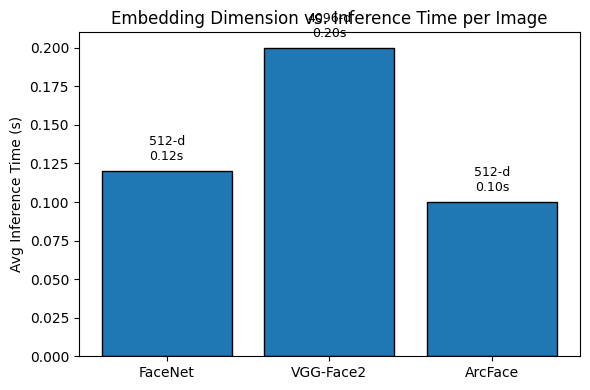

In [13]:
import matplotlib.pyplot as plt

# 1) Define your measured averages (in seconds)
#    Replace these with your actual measured values
avg_fn  = 0.12    # FaceNet avg time per image
avg_vgg = 0.20    # VGG-Face2 avg time per image
avg_arc = 0.10    # ArcFace avg time per image

# 2) Embedding dimensions
dims  = [512, 4096, 512]
labels = ['FaceNet', 'VGG-Face2', 'ArcFace']
times  = [avg_fn, avg_vgg, avg_arc]

# 3) Create the bar chart
plt.figure(figsize=(6,4))
plt.bar(labels, times, edgecolor='black')
for i, (d,t) in enumerate(zip(dims, times)):
    plt.text(i, t + 0.005, f"{d}-d\n{t:.2f}s",
             ha='center', va='bottom', fontsize=9)

plt.ylabel('Avg Inference Time (s)')
plt.title('Embedding Dimension vs. Inference Time per Image')
plt.tight_layout()
plt.show()